In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
class InputNormalizer():
    def fit(self, train):
        self.train_mean = np.mean(train, axis=0)
        self.train_std = np.std(train, axis=0)
    def fit_transform(self, train):
        self.train_mean = np.mean(train, axis=0)
        self.train_std = np.std(train, axis=0)
        return (train-self.train_mean)/self.train_std
    def transform(self, test):
        return (test-self.train_mean)/self.train_std

In [72]:
class LinearSVMClassifier():
    # Linear SVM with SGD
    # learning rate decay: lr = m/(k+n), k = number of seasons, m = lr_numerator_factor, n = lr_denominator_factor
    
    def __init__(self, batch_size, lamda, lr_numerator_factor, lr_denominator_factor, step_size):
        self.batch_size = batch_size
        self.lamda = lamda
        self.lr_numerator_factor = lr_numerator_factor
        self.lr_denominator_factor = lr_denominator_factor
        self.step_size = step_size

        
        
    def batch(self, size):
        tmp = np.array(range(size))
        np.random.shuffle(tmp)
        # Returns an list of index array, each array in the list represents the set of data records in one batch
        # if the remainder less than batch_size, then the last batch will just be the remaining data records
        return [tmp[i*self.batch_size:min((i+1)*self.batch_size,size)] for i in range(int(np.ceil(size/self.batch_size)))]
    
    def fit_eval(self, train, train_label, epoch, val=None, val_label=None):
        # If validation set provided, then validation set is used for tune parameters and report accuracy or other metrics
        # If no validation set provided, then set aside random 50 samples for heldout set for each epoch 
        # The heldout set is used for tune parameters and report accuracy or other metrics
        # train, val: training/validation set features, of dim (n_samples, n_features)
        # train_label, val_label: training/validation set labels, of dim (n_samples, )
        accuracy = []
        coef_size = []
        feature_dim = train.shape[1]
        self.w = np.random.rand(feature_dim)
        self.b = 0 
        # If validation set provided
        if ((val is not None) and (val_label is not None)):
            X_train = train
            y_train = train_label
            X_val = val
            y_val = val_label
            
        for e in range(epoch):
            # If no validation set provided
            if ((val is None) or (val_label is None)):
                # Random select 50 for each epoch as held out set
                tmp = np.array(range(len(train_label)))
                np.random.shuffle(tmp)

                # Train set for the epoch
                X_train = train[tmp[:-50]]
                y_train = train_label[tmp[:-50]]

                # Held out set for the epoch
                X_val = train[tmp[-50:]]
                y_val = train_label[tmp[-50:]]
            
            batch_idx = self.batch(len(y_train))
            
            for i in range(len(batch_idx)):
                # Implementation of learning rate decay, Learning rate = m / (n+k), m, n -> hyper parameter, k -> # of season
                lr_numseason_factor = (e*np.ceil(len(batch_idx)/self.step_size)+np.floor(i/self.step_size))
                learning_rate = self.lr_numerator_factor/(self.lr_denominator_factor+lr_numseason_factor)
                
                # TODO: handle for the case where train_label/val_label is provided in the dim of (n_samples, 1)
                gradient_w = np.sum(np.expand_dims(np.where((y_train[batch_idx[i]]*(np.sum(self.w * X_train[batch_idx[i]], axis=1)+self.b))>1,0,-1),1)
                                    * np.expand_dims(y_train[batch_idx[i]],1) * X_train[batch_idx[i]], axis=0)/len(batch_idx[i]) + self.lamda * self.w
                gradient_b = np.sum(np.where((y_train[batch_idx[i]]*(np.sum(self.w * X_train[batch_idx[i]], axis=1)+self.b))>1,0,-1)
                                    * y_train[batch_idx[i]] )/len(batch_idx[i])
                
                self.w = self.w - learning_rate * gradient_w
                self.b = self.b - learning_rate * gradient_b
                
                if (i % self.step_size == 0):
                    
                    accuracy.append(self.score(X_val, y_val))
                    coef_size.append(np.sum(np.square(self.w)))
                   
                                    
        return accuracy, coef_size
    
    def fit(self, train, train_label, epoch):
        feature_dim = train.shape[1]
        self.w = np.random.rand(feature_dim)
        self.b = 0          
        batch_idx = self.batch(len(train_label))
        for e in range(epoch):
            for i in range(len(batch_idx)):
                # Implementation of learning rate decay, Learning rate = m / (n+k), m, n -> hyper parameter, k -> # of season
                lr_numseason_factor = (e*np.ceil(len(batch_idx)/self.step_size)+np.floor(i/self.step_size))
                learning_rate = self.lr_numerator_factor/(self.lr_denominator_factor+lr_numseason_factor)
                
                # TODO: handle for the case where train_label/val_label is provided in the dim of (n_samples, 1)
                gradient_w = np.sum(np.expand_dims(np.where((train_label[batch_idx[i]]*(np.sum(self.w * train[batch_idx[i]], axis=1)+self.b))>1,0,-1),1)
                                    * np.expand_dims(train_label[batch_idx[i]],1) * train[batch_idx[i]], axis=0)/len(batch_idx[i]) + self.lamda * self.w
                gradient_b = np.sum(np.where((train_label[batch_idx[i]]*(np.sum(self.w * train[batch_idx[i]], axis=1)+self.b))>1,0,-1)
                                    * train_label[batch_idx[i]] )/len(batch_idx[i])
                
                self.w = self.w - learning_rate * gradient_w
                self.b = self.b - learning_rate * gradient_b
        return
    
    def predict(self, test):
        return np.where((np.sum(self.w * test, axis=1) + self.b) >=0, 1, -1)
    
    def score(self, test, test_label):
        # test: test set features, of dim (n_samples, n_features)
        # test_label: test set labels, of dim (n_samples, )        
        y_predict = self.predict(test)
        return np.mean(y_predict == test_label)


In [5]:
# Read input training data
data = pd.read_csv('data/train.txt', header=None, names =['age','fnlwgt','education-num','capital-gain','capital-loss','hour-per-week','income'], usecols=[0,2,4,10,11,12,14])
X = np.array(data[['age','fnlwgt','education-num','capital-gain','capital-loss','hour-per-week']].values)
y = np.array(data['income'].values)
# Split training data into train set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size =0.1)
# Normalize input
input_normalizer = InputNormalizer()
X_train = input_normalizer.fit_transform(X_train)
X_val = input_normalizer.transform(X_val)
# Convert label classes to number
le = preprocessing.LabelEncoder()
y_train = (le.fit_transform(y_train)*2)-1
y_val = (le.transform(y_val)*2)-1


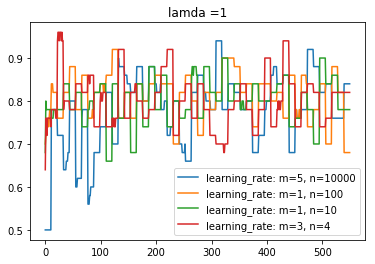

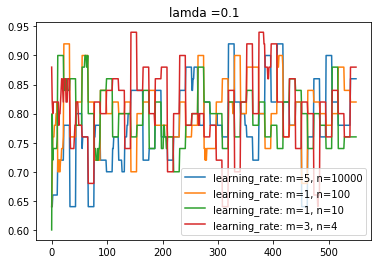

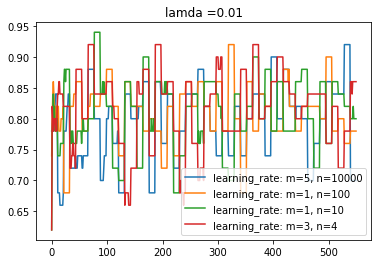

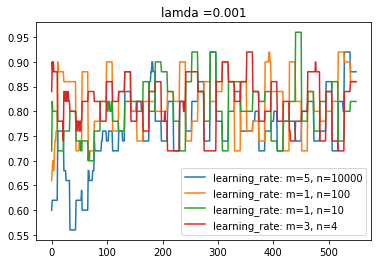

In [73]:
# For each regularization param, search for a learning rate using held out set
for lamda in (1, 0.1, 0.01, 0.001):
    fig = plt.figure()
    ax = plt.subplot(111)
    for (lr_numerator_factor, lr_denominator_factor) in ((5,10000),(1,100),(1,10), (3,4)):
        svm = LinearSVMClassifier(batch_size=128, lamda=0.01, lr_numerator_factor=lr_numerator_factor, lr_denominator_factor=lr_denominator_factor, step_size=30)
        accuracy, coef_size = svm.fit_eval(X_train, y_train, epoch = 50)

        ax.plot(range(len(accuracy)), accuracy, label='learning_rate: m='+str(lr_numerator_factor) +', n='+str(lr_denominator_factor))
        
    plt.title('lamda ='+str(lamda))
    ax.legend()
    plt.show()
        

In [86]:
# looks like for any regularization param, all different learning rate merges and fluctuates arounds the same values
# Train the model with 50 epoches more, and get the learning rate with highest average accuracy for the last 50 epoches
print("last 50 epoch, average held out accuracy")
for lamda in (1, 0.1, 0.01, 0.001):
    for (lr_numerator_factor, lr_denominator_factor) in ((5,10000),(1,100),(1,10), (3,4)):
        svm = LinearSVMClassifier(batch_size=128, lamda=lamda, lr_numerator_factor=lr_numerator_factor, lr_denominator_factor=lr_denominator_factor, step_size=30)
        accuracy, coef_size = svm.fit_eval(X_train, y_train, epoch = 100)
        print('lamda: '+str(lamda)+', learning rate: m='+str(lr_numerator_factor) +', n='+str(lr_denominator_factor)+', accuracy: '+str(np.mean(accuracy[-int(len(accuracy)/2):])))


last 50 epoch, average held out accuracy
lamda: 1, learning rate: m=5, n=10000, accuracy: 0.7816
lamda: 1, learning rate: m=1, n=100, accuracy: 0.7756000000000001
lamda: 1, learning rate: m=1, n=10, accuracy: 0.7779999999999999
lamda: 1, learning rate: m=3, n=4, accuracy: 0.78
lamda: 0.1, learning rate: m=5, n=10000, accuracy: 0.8036
lamda: 0.1, learning rate: m=1, n=100, accuracy: 0.7634545454545454
lamda: 0.1, learning rate: m=1, n=10, accuracy: 0.7807999999999999
lamda: 0.1, learning rate: m=3, n=4, accuracy: 0.7714181818181818
lamda: 0.01, learning rate: m=5, n=10000, accuracy: 0.7924727272727273
lamda: 0.01, learning rate: m=1, n=100, accuracy: 0.8061090909090909
lamda: 0.01, learning rate: m=1, n=10, accuracy: 0.806
lamda: 0.01, learning rate: m=3, n=4, accuracy: 0.8042545454545456
lamda: 0.001, learning rate: m=5, n=10000, accuracy: 0.8006181818181818
lamda: 0.001, learning rate: m=1, n=100, accuracy: 0.8164363636363636
lamda: 0.001, learning rate: m=1, n=10, accuracy: 0.8157090

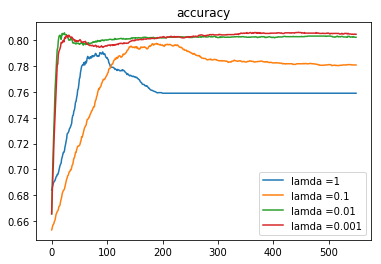

In [90]:
fig = plt.figure()
ax = plt.subplot(111)
# Search for regularization param using validation set
for (lamda,lr_numerator_factor, lr_denominator_factor) in ((1,5,10000), (0.1,5,10000), (0.01,1,100), (0.001,1,100)):

    svm = LinearSVMClassifier(batch_size=128, lamda=lamda, lr_numerator_factor=lr_numerator_factor, lr_denominator_factor=lr_denominator_factor, step_size=30)
    accuracy, coef_size = svm.fit_eval(X_train, y_train, 50, X_val, y_val)

    ax.plot(range(len(accuracy)), accuracy, label='lamda ='+str(lamda))
        
plt.title('accuracy')
ax.legend()
plt.show()

In [91]:
# With selected regularization and learning rate param, train the model with full training set
data = pd.read_csv('data/train.txt', header=None, names =['age','fnlwgt','education-num','capital-gain','capital-loss','hour-per-week','income'], usecols=[0,2,4,10,11,12,14])
X = np.array(data[['age','fnlwgt','education-num','capital-gain','capital-loss','hour-per-week']].values)
y = np.array(data['income'].values)
data = pd.read_csv('data/test.txt', header=None, names =['age','fnlwgt','education-num','capital-gain','capital-loss','hour-per-week'], usecols=[0,2,4,10,11,12])
X_test = np.array(data[['age','fnlwgt','education-num','capital-gain','capital-loss','hour-per-week']].values)
input_normalizer = InputNormalizer()
X = input_normalizer.fit_transform(X)
X_test = input_normalizer.transform(X_test)
le = preprocessing.LabelEncoder()
y = (le.fit_transform(y)*2)-1
svm = LinearSVMClassifier(batch_size = 128, lamda =0.001, lr_numerator_factor=1, lr_denominator_factor=100, step_size=30)
svm.fit(X, y, epoch=50)
y_predict = svm.predict(X_test)

In [93]:
# Convert the predicted label to original classes
le.inverse_transform(np.array((y_predict+1)/2,dtype='int'))

array([' <=50K', ' <=50K', ' >50K', ..., ' >50K', ' <=50K', ' <=50K'],
      dtype=object)

In [94]:
np.savetxt("submission.txt", le.inverse_transform(np.array((y_predict+1)/2,dtype='int')), fmt="%s")